### Multiple Time Series, Pre-trained Models and Covariates

This notebook serves as a tutorial for:
* Training a single model on multiple time series
* Using a pre-trained model to obtain forecasts for any time series unseen during training
* Training and using a model using covariates

First, some necessary imports:

In [1]:
import gc
gc.collect()

297

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel
from darts.metrics import mape, smape, mse, rmse, ope, r2_score, rmsle, coefficient_of_variation, metrics, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

torch.manual_seed(1); np.random.seed(1)  # for reproducibility

### Read Data
Let's start by reading two time series - one containing the monthly number of air passengers, and another containing the monthly milk production per cow. These time series have not much to do with each other, except that they both have a monthly frequency with a marked yearly periodicity and upward trend, and (completely coincidentaly) they contain values of a comparable order of magnitude.

In [3]:
df = pd.read_excel("C:/Users/KAPLAN/Desktop/masterthesis_fulldata_interpolated_ready.xlsx", engine='openpyxl')

In [4]:
list(df.columns.values)
list(df)

['Date',
 'Daily_Sum_CrudeBERT',
 'Label_CrudeBERT',
 'Cuml_CurdeBERT',
 'Daily_Sum_CrudeBERTv2',
 'Label_CrudeBERTv2',
 'Cuml_CrudeBERTv2',
 'Daily_Sum_CrudeBERTv2_GT',
 'Label_CrudeBERTv2_GT',
 'Cuml_CrudeBERTv2_GT',
 'Daily_Sum_CrudeBERT_T4',
 'Label_CrudeBERT_T4',
 'Cuml_CrudeBERT_T4',
 'Daily_Sum_FinBERT',
 'Label_FinBERT',
 'Cuml_FinBERT',
 'Daily_Sum_RavenPack',
 'Label_RavenPack',
 'Cuml_RavenPack',
 'Price_t0',
 'Return_t0',
 'Label_Price_t0',
 'Price_t1',
 'Return_t1',
 'Label_Price_t1',
 'Price_t2',
 'Return_t2',
 'Label_Price_t2',
 'Price_t3',
 'Return_t3',
 'Label_Price_t3',
 'Google_Trend_K_S_Crude_Oil']

#### Sentiment Scores

      Cuml_CrudeBERTv2_GT
7752           244.728556
7753           247.452105
7754           248.946696
7755           249.007053
7756           248.922511
7757           248.413578
7758           250.058131
7759           251.706035
7760           251.236513
7761           251.072913


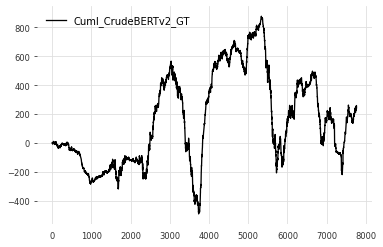

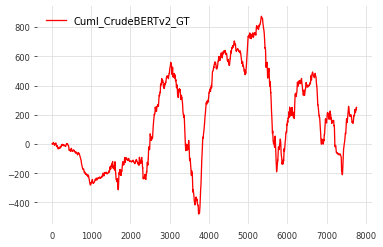

In [5]:
#Set window for rolling average transformation
window = 7
# Tail-rolling average transform
sentiment_data = df[['Cuml_CrudeBERTv2_GT']]
rolling = sentiment_data.rolling(window=window)
rolling_mean = rolling.mean()
print(rolling_mean.tail(10))
# plot original and transformed dataset
sentiment_data.plot()
rolling_mean.plot(color='red')
df = df.assign(R_average_sentiment_data = rolling_mean)
plt.show()
df['R_average_sentiment_data'].fillna(0, inplace = True)
series_sentiment = TimeSeries.from_dataframe(df, 'Date', ['R_average_sentiment_data'])

#### Oil Price

       Price_t0
7752  61.788050
7753  61.299478
7754  61.093764
7755  61.029478
7756  60.933762
7757  60.699039
7758  60.700467
7759  61.099039
7760  60.810467
7761  61.223325


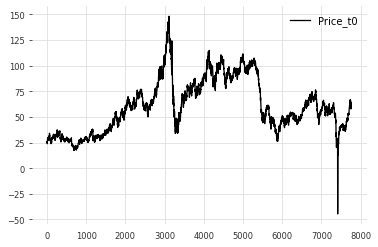

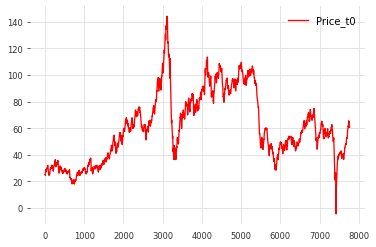

In [6]:
# Tail-rolling average transform
price_data = df[['Price_t0']]
rolling = price_data.rolling(window=window)
rolling_mean = rolling.mean()
print(rolling_mean.tail(10))
# plot original and transformed dataset
price_data.plot()
rolling_mean.plot(color='red')
df = df.assign(R_average_price_data = rolling_mean)
plt.show()
df['R_average_price_data'].fillna(0, inplace = True)
series_price = TimeSeries.from_dataframe(df, 'Date', ['R_average_price_data'])

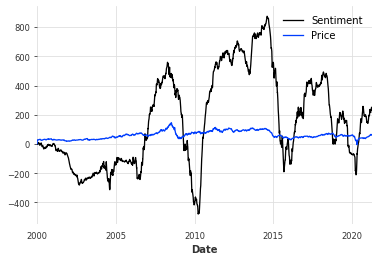

In [7]:
series_sentiment.plot(label='Sentiment')
series_price.plot(label='Price')
plt.legend();

In [8]:
list(df.columns.values)
list(df)

['Date',
 'Daily_Sum_CrudeBERT',
 'Label_CrudeBERT',
 'Cuml_CurdeBERT',
 'Daily_Sum_CrudeBERTv2',
 'Label_CrudeBERTv2',
 'Cuml_CrudeBERTv2',
 'Daily_Sum_CrudeBERTv2_GT',
 'Label_CrudeBERTv2_GT',
 'Cuml_CrudeBERTv2_GT',
 'Daily_Sum_CrudeBERT_T4',
 'Label_CrudeBERT_T4',
 'Cuml_CrudeBERT_T4',
 'Daily_Sum_FinBERT',
 'Label_FinBERT',
 'Cuml_FinBERT',
 'Daily_Sum_RavenPack',
 'Label_RavenPack',
 'Cuml_RavenPack',
 'Price_t0',
 'Return_t0',
 'Label_Price_t0',
 'Price_t1',
 'Return_t1',
 'Label_Price_t1',
 'Price_t2',
 'Return_t2',
 'Label_Price_t2',
 'Price_t3',
 'Return_t3',
 'Label_Price_t3',
 'Google_Trend_K_S_Crude_Oil',
 'R_average_sentiment_data',
 'R_average_price_data']

### Preprocessing
Usually neural networks tend to work better on normalised/standardised data. Here we'll use the `Scaler` class to normalise both of our time series between 0 and 1:

Some applications may require your datapoints to be between 0 and 1 (e.g. to feed a time series to a Neural Network based forecasting model). This is easily achieved using the default Scaler, which is a wrapper around sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1)).

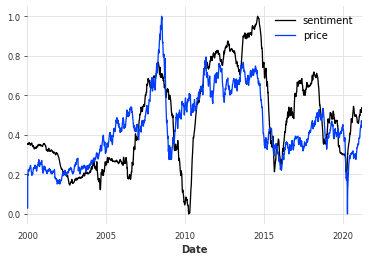

In [9]:
scaler_sentiment, scaler_price = Scaler(), Scaler()
series_sentiment_scaled = scaler_sentiment.fit_transform(series_sentiment)
series_price_scaled = scaler_price.fit_transform(series_price)

series_sentiment_scaled.plot(label='sentiment')
series_price_scaled.plot(label='price')
plt.legend();

### Train / Validation split
Let's keep the last 36 months of both series as validation:

In [10]:
timestamp = '2021-03-26'
train_price, val_price = series_price_scaled.split_before(pd.Timestamp(timestamp))
train_sentiment, val_sentiment = series_sentiment_scaled.split_before(pd.Timestamp(timestamp))
nsplit = len(series_price_scaled)-len(train_price)

In [11]:
input_chunk_length= 14
output_chunk_length= 7
n_epochs= 40

In [12]:
model_price_sentiment = NBEATSModel(input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, n_epochs=n_epochs)

In [13]:
start_time = time.time()
model_price_sentiment.fit([train_sentiment, train_price], verbose=True)
print(" Time passed: {} seconds ".format(time.time() - start_time))

[2021-08-09 11:11:22,888] INFO | darts.models.torch_forecasting_model | Train dataset contains 15470 samples.
[2021-08-09 11:11:22,888] INFO | darts.models.torch_forecasting_model | Train dataset contains 15470 samples.


Training loss: 0.0001
 Time passed: 1854.760530948639 seconds 


CoV = 1.00%
MAE = 0.00%
MAPE = 0.84%
SMAPE = 0.84%
MSE = 0.00%
RMSE = 0.00%
RMSLE = 0.00%
R2 = -11.06%


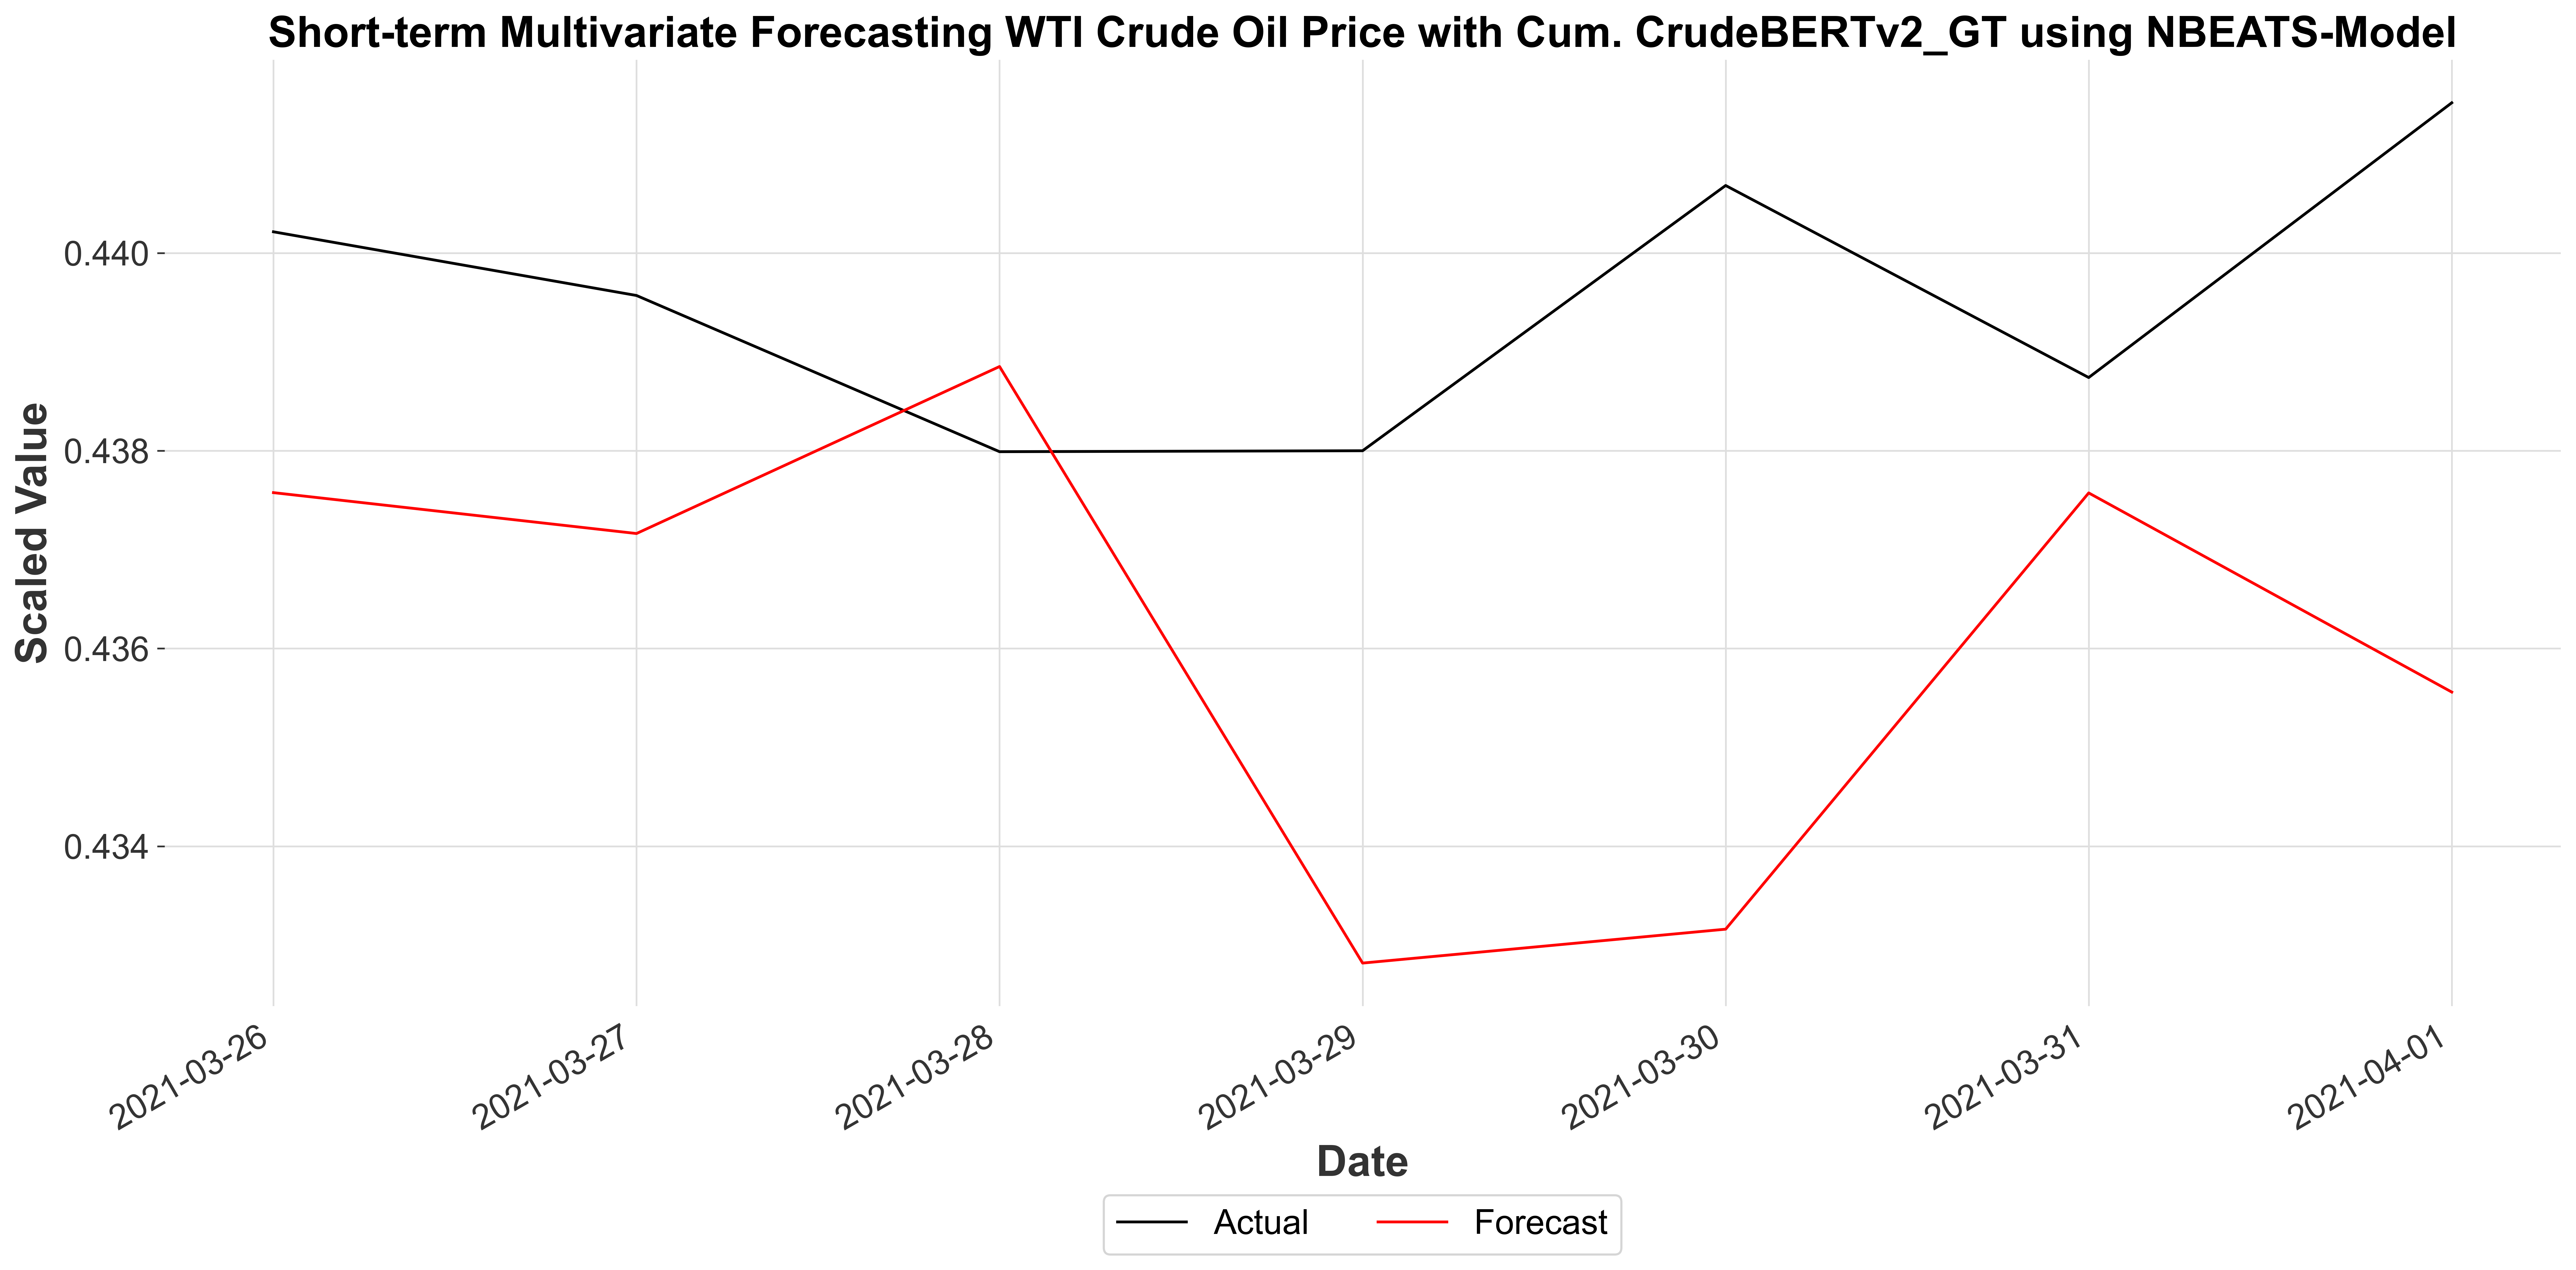

In [14]:
plot_name = "Short-term Multivariate Forecasting WTI Crude Oil Price with Cum. CrudeBERTv2_GT using NBEATS-Model"
pred = model_price_sentiment.predict(n=nsplit, series=train_price)
fsl = 20
fst = 16
plt.rcParams['font.sans-serif'] = "Arial"
plt.figure(figsize=(20, 9), dpi=600)
plt.title(plot_name, fontsize=fsl, weight='bold')
val_price.plot(color='black', x_compat=True, label='Actual')
pred.plot(color='red', x_compat=True, label='Forecast')
plt.legend(fontsize=fst,loc='upper center', bbox_to_anchor= (0.5, -0.2), ncol=6, borderaxespad=0, frameon=True)
plt.xticks(fontsize=fst)
plt.yticks(fontsize=fst)
plt.xlabel('Date', fontsize=fsl)
plt.ylabel('Scaled Value', fontsize=fsl)
plt.savefig('C:/Users/KAPLAN/Desktop/graphs_mt/eval/'+plot_name+'.png', dpi=1200, bbox_inches="tight")
# select metric: coefficient_of_variation, mape, smape, mse, rmse, ope, r2_score, rmsle or mae
print('CoV = {:.2f}%'.format(coefficient_of_variation(series_price_scaled, pred)))
print('MAE = {:.2f}%'.format(mae(series_price_scaled, pred)))
print('MAPE = {:.2f}%'.format(mape(series_price_scaled, pred)))
print('SMAPE = {:.2f}%'.format(smape(series_price_scaled, pred)))
print('MSE = {:.2f}%'.format(mse(series_price_scaled, pred)))
print('RMSE = {:.2f}%'.format(rmse(series_price_scaled, pred)))
print('RMSLE = {:.2f}%'.format(rmsle(series_price_scaled, pred)))
print('R2 = {:.2f}%'.format(r2_score(series_price_scaled, pred)))